In [60]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import json
import csv
from tqdm import tqdm, trange
import sys

# DATA Loading

In [61]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [62]:
from google.colab import files
#uploaded = files.upload()

In [63]:
dataa = pd.read_csv('/content/drive/My Drive/NER/df200.csv')

In [65]:
dataa = dataa.rename(columns={'Tag':'tag'})
dataa.head(10)

,ID,Doc_ID,Sent_ID,Word,tag
0,0,0,0,醫,O
1,1,0,0,師,O
2,2,0,0,：,O
3,3,0,0,啊,O
4,4,0,0,回,O
5,5,0,0,去,O
6,6,0,0,還,O
7,7,0,0,好,O
8,8,0,0,嗎,O
9,9,0,0,？,O


In [66]:
s = dataa.groupby(['Doc_ID','Sent_ID']).count()
max(s['tag'])

493

In [67]:
s[s['tag']>350]

ID  Word  tag
Doc_ID Sent_ID                
112    199      432   432  432
       200      371   371  371
115    47       356   356  356
170    54       493   493  493
94     2        488   488  488
       92       359   359  359

## BERT MODEL

In [68]:
!pip install transformers==2.6.0

In [69]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__

'1.7.0+cu101'

In [70]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
       # agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
       #                                                    s["POS"].values.tolist(),
        #                                                   s["Tag"].values.tolist())]
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby(["Doc_ID","Sent_ID"]).apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["{}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [71]:
getter = SentenceGetter(dataa)

In [72]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]

In [73]:
tag_values = list(set(dataa["tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [74]:
MAX_LEN = 400
bs = 16

In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [76]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [77]:
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese', do_lower_case=False) 

In [78]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [79]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
labels = [[s[1] for s in sentence] for sentence in getter.sentences]

In [80]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

In [81]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [82]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [83]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [84]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [85]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags, random_state=218, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,random_state=218, test_size=0.1)

In [86]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [87]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [88]:
import transformers
from transformers import BertForTokenClassification, AdamW

from transformers import BertTokenizer, BertForSequenceClassification
import torch
transformers.__version__

'2.6.0'

In [89]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-chinese",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

In [90]:
import torch
torch.cuda.empty_cache()

In [91]:
model.cuda();

In [92]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [93]:
from transformers import get_linear_schedule_with_warmup

epochs = 70
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [94]:
!pip install seqeval

In [95]:
from seqeval.metrics import f1_score

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [96]:
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        eval_accuracy += flat_accuracy(logits, label_ids)
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print()



Epoch:   0%|          | 0/70 [00:00<?, ?it/s]


RuntimeError: ignored

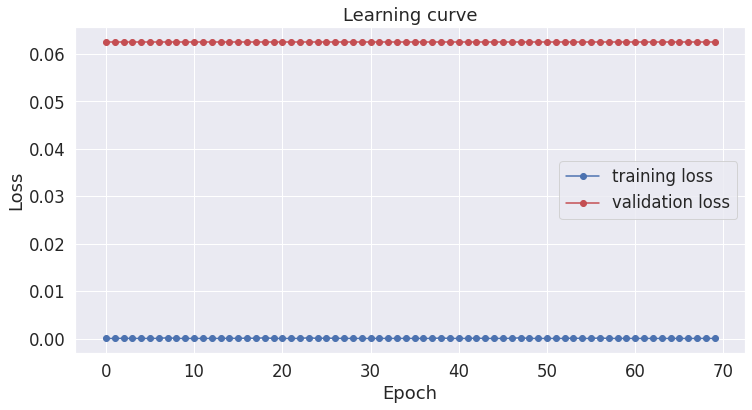

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

# predict

In [ ]:
#uploaded = files.upload()

In [ ]:
df_test = pd.read_csv('/content/drive/My Drive/NER/test0.csv')

In [ ]:
df_test.head(10)

,Unnamed: 0,ID,Doc_ID,Sent_ID,Word
0,0,0,0,0,醫
1,1,1,0,0,師
2,2,2,0,0,：
3,3,3,0,0,最
4,4,4,0,0,近
5,5,5,0,0,人
6,6,6,0,0,有
7,7,7,0,0,沒
8,8,8,0,0,有
9,9,9,0,0,什


In [ ]:
doc_sent_word = []
for i in range(len(set(df_test['Doc_ID']))-1):
  df_test2 = df_test[df_test['Doc_ID'] == str(i)]
  sent_word = []
  for j in range(len(set(df_test2['Sent_ID']))-1):
    df_test3 = df_test2[df_test2['Sent_ID'] == str(j)].reset_index(drop=True)
    word = []
    for q in range(len(df_test3)):
      word.append(df_test3['Word'][q]) 
    sent_word.append(word)
  doc_sent_word.append(sent_word)

In [ ]:
doc2 = []
label3 = []
for all_doc in range(len(doc_sent_word)):

  sent2 = []
  label2 = []
  for all_sent in range(len(doc_sent_word[all_doc])):

    tokenized_sentence = tokenizer.encode(doc_sent_word[all_doc][all_sent])
    input_ids = torch.tensor([tokenized_sentence]).cuda()
    with torch.no_grad():
      output = model(input_ids)
    label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)
    tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
    new_tokens, new_labels = [], []
    for token, label_idx in zip(tokens, label_indices[0]):
      if token.startswith("##"):
          new_tokens[-1] = new_tokens[-1] + token[2:]
      else:
          new_labels.append(tag_values[label_idx])
          new_tokens.append(token)
    sent2.append(new_tokens)
    label2.append(new_labels)
  doc2.append(sent2)
  label3.append(label2)

RuntimeError: ignored

In [ ]:
print('字的 文章數: {}'.format(len(doc2)))
print('Label 文章數: {}'.format(len(label3)))
print('--------------------------')
print('字的 第i篇文章句子數: {}'.format(len(doc2[0])))
print('Label 第i篇文章句子數: {}'.format(len(label3[0])))
print('--------------------------')
print('字的 第i篇文章地j句句子 字數: {}'.format(len(doc2[0][10])))
print('Label 第i篇文章地j句句子 字數: {}'.format(len(label3[0][10])))

In [ ]:
# 每句句子開頭都有CLS 結尾有SEP 要去掉

In [ ]:
from itertools import chain

In [ ]:
doc = doc2
label = label3

In [ ]:
# 內文
for i in range(159):
  for j in range(len(doc[i])):
    doc[i][j] = doc[i][j][1:-1]
for i in range(159):
  doc[i] = list(chain(*doc[i]))

In [ ]:
# 標籤
for i in range(159):
  for j in range(len(label[i])):
    label[i][j] = label[i][j][1:-1]
for i in range(159):
  label[i] = list(chain(*label[i]))

In [ ]:
label[1][112][2:]

'money'

In [ ]:
label[1].index('I-time')

180

In [ ]:
output="article_id\tstart_position\tend_position\tentity_text\tentity_type\n"
for test_id in tqdm(range(len(label))):
    pos=0
    start_pos=None
    end_pos=None
    entity_text=None
    entity_type=None
    for pred_id in range(len(label[test_id])):
        if label[test_id][pred_id][0]=='B':
            start_pos=pos
            entity_type=label[test_id][pred_id][2:]
        elif label[test_id][pred_id-1][0]=='O' and label[test_id][pred_id][0]=='I':
            start_pos=pos
            entity_type=label[test_id][pred_id][2:]
        elif start_pos is not None and label[test_id][pred_id][0]=='I' and label[test_id][pred_id+1][0]=='O':
            end_pos=pos
            entity_text=''.join([doc[test_id][position] for position in range(start_pos,end_pos+1)])
            line=str(test_id)+'\t'+str(start_pos)+'\t'+str(end_pos+1)+'\t'+entity_text+'\t'+entity_type
            output+=line+'\n'
        pos+=1

100%|██████████| 159/159 [00:00<00:00, 1096.10it/s]


In [ ]:
output_path='/content/drive/My Drive/NER/output11.tsv'
with open(output_path,'w',encoding='utf-8') as f:
    f.write(output)

In [ ]:
print(output)

article_id	start_position	end_position	entity_text	entity_type
0	198	200	新樓	location
0	227	229	麻豆	location
0	237	239	麻豆	location
1	76	80	零點七九	med_exam
1	94	96	八八	med_exam
1	111	113	六零	med_exam
1	122	124	六零	med_exam
1	179	181	二零	time
1	182	184	一九	time
1	258	261	二點六	med_exam
1	360	363	黃醫師	name
1	366	369	六點六	med_exam
1	385	388	六點六	med_exam
1	394	397	八點三	med_exam
1	407	410	八點三	time
1	414	417	四個月	time
1	418	421	八點三	time
1	463	466	六點二	med_exam
1	469	472	三個月	time
1	626	629	黃醫師	name
1	663	666	格里曼	name
1	670	673	格里曼	name
1	720	723	格里曼	name
1	737	739	捷糖	name
1	747	750	格里曼	name
1	754	757	格里曼	name
1	867	869	二一	time
1	873	875	二一	time
1	881	884	一二天	time
1	890	893	一二天	time
1	902	906	三個星期	time
2	170	174	一一點零	med_exam
2	245	249	一點四五	med_exam
2	275	278	五點零	money
2	285	288	五點零	money
2	390	393	三個月	time
2	402	405	三個月	time
2	424	426	小梅	name
2	678	680	五五	med_exam
2	681	683	五七	med_exam
2	699	701	五二	med_exam
2	792	795	兩個月	time
2	1090	1094	七點五六	med_exam
2	1151	1155	四點零塊	money
2	1239	1241	三五	med_exam
2	1246	1248

In [ ]:
len(output)/5

11553.0

# find unk


In [ ]:
df_test = pd.read_csv('/content/drive/My Drive/NER/df200(2).csv')

df_test.tail(20)


,ID,Doc_ID,Sent_ID,Word,Tag
415709,415709,199,58,踏,O
415710,415710,199,58,車,O
415711,415711,199,58,可,O
415712,415712,199,58,以,O
415713,415713,199,58,",",O
415714,415714,199,58,小,B-name
415715,415715,199,58,美,I-name
415716,415716,199,58,",",O
415717,415717,199,58,那,O
415718,415718,199,58,我,O


In [ ]:

doc_sent_word = []
for i in range(len(set(df_test['Doc_ID']))-1):
  df_test2 = df_test[df_test['Doc_ID'] == str(i)]
  sent_word = []
  for j in range(len(set(df_test2['Sent_ID']))):
    df_test3 = df_test2[df_test2['Sent_ID'] == str(j)].reset_index(drop=True)
    word = []
    for q in range(len(df_test3)):
      word.append(df_test3['Word'][q]) 
    sent_word.append(word)
  doc_sent_word.append(sent_word)

doc2 = []
label3 = []
for all_doc in range(len(doc_sent_word)):

  sent2 = []
  label2 = []
  for all_sent in range(len(doc_sent_word[all_doc])):

    tokenized_sentence = tokenizer.encode(doc_sent_word[all_doc][all_sent])
    input_ids = torch.tensor([tokenized_sentence]).cuda()
    with torch.no_grad():
      output = model(input_ids)
    label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)
    tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
    new_tokens, new_labels = [], []
    for token, label_idx in zip(tokens, label_indices[0]):
      if token.startswith("##"):
          new_tokens[-1] = new_tokens[-1] + token[2:]
      else:
          new_labels.append(tag_values[label_idx])
          new_tokens.append(token)
    sent2.append(new_tokens)
    label2.append(new_labels)
  doc2.append(sent2)
  label3.append(label2)


In [ ]:
from itertools import chain

doc = doc2.copy()
label = label3.copy()

# 內文
for i in range(200):
  for j in range(len(doc[i])):
    doc[i][j] = doc[i][j][1:-1]
for i in range(200):
  doc[i] = list(chain(*doc[i]))

# 標籤
for i in range(200):
  for j in range(len(label[i])):
    label[i][j] = label[i][j][1:-1]
for i in range(200):
  label[i] = list(chain(*label[i]))


In [ ]:

a_Doc = []

for i in range(len(doc_sent_word)):
  a_sent = []
  for j in range(len(doc_sent_word[i])):
    aDoc_word = []
    for k in range(len(doc_sent_word[i][j])):
      aDoc_word.append(doc_sent_word[i][j][k])
    a_sent = a_sent + aDoc_word
  a_Doc.append(a_sent)

a = 0
for i in range(len(doc)):
  for j in range(len(doc[i])):
    if doc[i][j] == '[UNK]':
      print('{}, {}, {}'.format(doc[i][j], label[i][j], a_Doc[i][j] ))
      a += 1
a


[UNK], O, A
[UNK], O, S
[UNK], O, T
[UNK], O, A
[UNK], O, L
[UNK], O, T
[UNK], O, G
[UNK], O, O
[UNK], O, T
[UNK], O, G
[UNK], O, P
[UNK], O, T
[UNK], O, R
[UNK], O, P
[UNK], O, D
[UNK], O, D
[UNK], O, A
[UNK], O, A
[UNK], O, A
[UNK], O, B
[UNK], O, B
[UNK], O, B
[UNK], O, B
[UNK], O, B
[UNK], O, B
[UNK], O, A
[UNK], O, O
[UNK], O, D
[UNK], O, O
[UNK], O, O
[UNK], O, O
[UNK], O, O
[UNK], O, O
[UNK], O, O
[UNK], O, O
[UNK], O, X
[UNK], O, O
[UNK], O, O
[UNK], O, O
[UNK], O, O
[UNK], O, X
[UNK], O, O
[UNK], O, D
[UNK], O, D
[UNK], O, O
[UNK], O, H
[UNK], O, P
[UNK], O, V
[UNK], O, H
[UNK], O, P
[UNK], O, V
[UNK], O, B
[UNK], O, A
[UNK], O, B
[UNK], O, O
[UNK], O, B
[UNK], O, B
[UNK], O, B
[UNK], O, A
[UNK], O, O
[UNK], O, O
[UNK], O, O
[UNK], O, O
[UNK], O, E
[UNK], O, X
[UNK], O, X
[UNK], O, X
[UNK], O, X
[UNK], O, G
[UNK], O, O
[UNK], O, O
[UNK], O, G
[UNK], O, L
[UNK], O, E
[UNK], O, L
[UNK], O, I
[UNK], O, N
[UNK], O, D
[UNK], O, D
[UNK], O, R
[UNK], O, L
[UNK], O, E
[UNK], O, E
[UNK

1294

In [ ]:
a_Doc = []
for i in range(len(doc_sent_word)):
  a_sent = []
  for j in range(len(doc_sent_word[i])):
    aDoc_word = []
    for k in range(len(doc_sent_word[i][j])):
      aDoc_word.append(doc_sent_word[i][j][k])
    a_sent = a_sent + aDoc_word
  a_Doc.append(a_sent)
set2 = []
a = 0
for i in range(len(doc)):
  for j in range(len(doc[i])):
    if doc[i][j] == '[UNK]':
      #print('{}, {}, {}'.format(doc[i][j], label[i][j], a_Doc[i][j] ))
      set2.append(a_Doc[i][j])
      a += 1
a

12

In [ ]:
set(set2)

{' ', '搥', '擤'}

In [ ]:

with open('/content/drive/My Drive/NER/UNK_test2.txt', 'w') as f:
  for i in range(len(doc)):
    f.write('------------------------------------')
    f.write('\n')
    f.write('article{}'.format(i))
    f.write('\n')

    for j in range(len(doc[i])):
      if doc[i][j] == '[UNK]':
        f.write(doc[i][j])
        f.write('\t')
        f.write(label[i][j])
        f.write('\t')
        f.write(a_Doc[i][j])
        f.write('\n')

In [ ]:
article_ids = []
entity_text_lst = []
entity_type_lst = []
entity_text_lst2 = []
entity_type_lst2 = []
for article_id in tqdm(range(len(doc2))):

  for sent in range(len(doc2[article_id])-1):
    if label3[article_id][sent][0] == "O" and label3[article_id][sent+1][0] == "I":
      article_id = article_id
      entity_text = doc2[article_id][sent+1]
      entity_type = label3[article_id][sent+1]
      entity_text_1 = doc2[article_id][sent]
      entity_type_1 = label3[article_id][sent]
      article_ids.append(article_id)
      entity_text_lst.append(entity_text)
      entity_text_lst2.append(entity_text_1)
      entity_type_lst.append(entity_type)
      entity_type_lst2.append(entity_type_1)

d = {'article_id': article_ids, 'entity_text_lst': entity_text_lst,
     'entity_type_lst': entity_type_lst, 'entity_text_lst2': entity_text_lst2,
     'entity_type_lst2': entity_type_lst2}
df = pd.DataFrame(data=d)

100%|██████████| 200/200 [00:00<00:00, 20809.72it/s]


In [ ]:
df

,article_id,entity_text_lst,entity_type_lst,entity_text_lst2,entity_type_lst2


In [ ]:
len(outputs)

2

In [ ]:
len(outputs[1][0][0])

31

In [ ]:
len(outputs[1][0][5])

31

In [ ]:
len(outputs[1][0][0])

31

In [ ]:
outputs[1]

tensor([[[13.8251, -1.1175, -1.2199,  ..., -0.6933, -1.1652, -1.4129],
         [13.8255, -1.0848, -1.2672,  ..., -0.7316, -1.2300, -1.4670],
         [13.8276, -1.0424, -1.2744,  ..., -0.7224, -1.2340, -1.4617],
         ...,
         [13.7451, -1.1874, -1.2240,  ..., -0.8483, -1.2035, -1.4423],
         [13.7495, -1.1655, -1.1960,  ..., -0.8524, -1.2692, -1.4305],
         [13.7573, -1.1819, -1.2088,  ..., -0.8162, -1.2644, -1.4298]]],
       device='cuda:0')

In [ ]:
df_test.tail(35)

,ID,Doc_ID,Sent_ID,Word
270696,270696,158,90,問
270697,270697,158,90,啦
270698,270698,158,90,","
270699,270699,158,90,齁
270700,270700,158,90,。
270701,270701,158,91,民
270702,270702,158,91,眾
270703,270703,158,91,:
270704,270704,158,91,好
270705,270705,158,91,啊
